In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

import datautils

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
num_classes = 11
feature_dim = datautils.FEATURE_DIM
ivector_dim = 800

In [3]:
#print("Loading GloVe")
#glove_dict = datautils.load_glove_dict()
print("Loading training data")
#X_train, lens_train = datautils.load_train_examples(glove_dict)
ivectors_train = datautils.load_train_ivectors()
y_train = datautils.load_train_labels()
print("Loading dev data")
#X_val, lens_val = datautils.load_dev_examples(glove_dict)
y_val = datautils.load_dev_labels()
ivectors_val = datautils.load_dev_ivectors()

Loading training data
Loading dev data


In [4]:
# Center and normalize the ivectors
ivectors_train -= np.mean(ivectors_train, axis=0)
ivectors_train /= np.std(ivectors_train, axis=0)

ivectors_val -= np.mean(ivectors_val, axis=0)
ivectors_val /= np.std(ivectors_val, axis=0)

print(np.mean(ivectors_train), np.std(ivectors_train))
print(np.mean(ivectors_val), np.std(ivectors_val))

-9.4197e-10 1.0
5.63535e-10 1.0


In [5]:
#print("X_train:", X_train.shape)
print("ivectors_train:", ivectors_train.shape)
#print("lens_train:", lens_train.shape)
print("y_train:", y_train.shape)

#print("X_val:", X_val.shape)
print("ivectors_val:", ivectors_val.shape)
#print("lens_val:", lens_val.shape)
print("y_val:", y_val.shape)

ivectors_train: (11000, 800)
y_train: (11000,)
ivectors_val: (1100, 800)
y_val: (1100,)


In [6]:
tf.reset_default_graph()
#X = tf.placeholder(tf.float32, [None, None, feature_dim])
y = tf.placeholder(tf.int64, [None])
ivectors = tf.placeholder(tf.float32, [None, ivector_dim])
#lens = tf.placeholder(tf.int64, [None])

lr = 1e-3
dr = 0.2

learning_rate = tf.placeholder(tf.float32)
dropout = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool)

#cell = tf.contrib.rnn.GRUCell(1024)
#outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32, sequence_length=lens) # Outputs: N x L x W
# TODO: figure out why some transcriptions have length 0
#h1 = tf.concat((states, ivectors), axis=1)

fc1 = tf.layers.dense(ivectors, 512, activation=tf.nn.relu)
d1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
fc2 = tf.layers.dense(d1, 256, activation=tf.nn.relu)
d2 = tf.layers.dropout(fc2, rate=dropout, training=is_training)
y_out = tf.layers.dense(d2, num_classes)

mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y, num_classes), logits=y_out))
optimizer = tf.train.AdamOptimizer(learning_rate)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [7]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch))):
            # generate indicies for the batch
            start_idx = (i*batch)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch]
            
            # get batch size
            actual_batch_size = yd[i:i+batch].shape[0]

            # create a feed dictionary for this batch
            feed_dict = {ivectors: Xd[idx],
                         y: yd[idx],
                         is_training: training_now,
                         learning_rate: lr,
                         dropout: dr
                         }
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            iter_cnt += 1
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))            
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_losses = []
train_acc = []
val_losses = []
val_acc = []

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, "gru-model-11")
with open("gru-model.txt") as logs:
    train_losses = [ float(val) for val in logs.readline().split() ]
    val_losses = [ float(val) for val in logs.readline().split() ]
    train_acc = [ float(val) for val in logs.readline().split() ]
    val_acc = [ float(val) for val in logs.readline().split() ]

Iteration 25: with minibatch training loss = 0.214 and accuracy of 0.91
Iteration 50: with minibatch training loss = 0.229 and accuracy of 0.91
Iteration 75: with minibatch training loss = 0.198 and accuracy of 0.94
Epoch 1, Overall loss = 0.255 and accuracy of 0.911


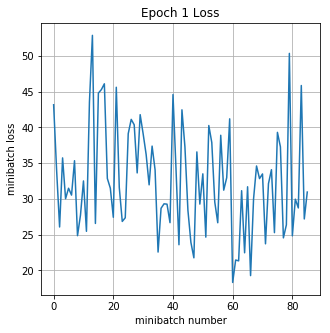

Epoch 1, Overall loss = 0.7 and accuracy of 0.794
Iteration 25: with minibatch training loss = 0.197 and accuracy of 0.94
Iteration 50: with minibatch training loss = 0.282 and accuracy of 0.9
Iteration 75: with minibatch training loss = 0.474 and accuracy of 0.85
Epoch 1, Overall loss = 0.244 and accuracy of 0.915


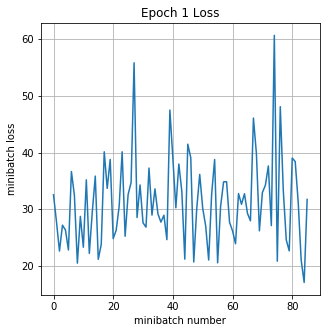

Epoch 1, Overall loss = 0.697 and accuracy of 0.796
Iteration 25: with minibatch training loss = 0.184 and accuracy of 0.91
Iteration 50: with minibatch training loss = 0.201 and accuracy of 0.94
Iteration 75: with minibatch training loss = 0.347 and accuracy of 0.87
Epoch 1, Overall loss = 0.237 and accuracy of 0.915


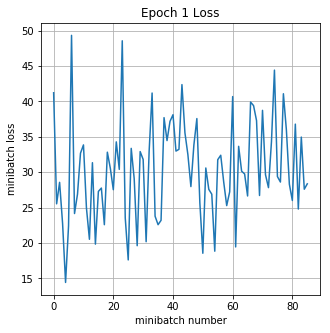

Epoch 1, Overall loss = 0.698 and accuracy of 0.794
Iteration 25: with minibatch training loss = 0.262 and accuracy of 0.94
Iteration 50: with minibatch training loss = 0.278 and accuracy of 0.9
Iteration 75: with minibatch training loss = 0.242 and accuracy of 0.9
Epoch 1, Overall loss = 0.236 and accuracy of 0.918


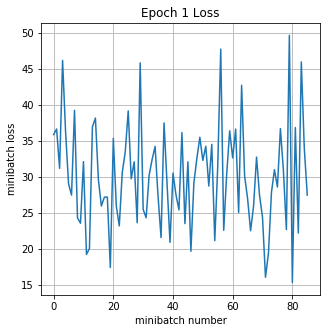

Epoch 1, Overall loss = 0.701 and accuracy of 0.797
Iteration 25: with minibatch training loss = 0.2 and accuracy of 0.91
Iteration 50: with minibatch training loss = 0.257 and accuracy of 0.88
Iteration 75: with minibatch training loss = 0.185 and accuracy of 0.95
Epoch 1, Overall loss = 0.225 and accuracy of 0.922


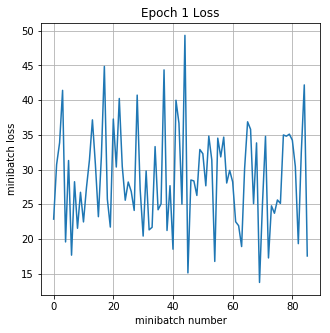

Epoch 1, Overall loss = 0.702 and accuracy of 0.796


In [13]:
epochs = 5
lr = 1e-4
dr = 0.6
for i in range(epochs):
    loss, acc = run_model(session=sess,
                          predict=y_out,
                          loss_val=mean_loss,
                          Xd=ivectors_train,
                          yd=y_train,
                          epochs=1,
                          batch=128,
                          print_every=25,
                          training=train_step,
                          plot_losses=True)
    train_losses.append(loss)
    train_acc.append(acc)
    loss, acc = run_model(session=sess,
                          predict=y_out,
                          loss_val=mean_loss,
                          Xd=ivectors_val,
                          yd=y_val,
                          epochs=1,
                          batch=ivectors_val.shape[0],
                          print_every=1,
                          training=None,
                          plot_losses=False)
    val_losses.append(loss)
    val_acc.append(acc)
    saver = tf.train.Saver()
    saver.save(sess, './checkpoints/ivector-model', global_step=len(val_acc))

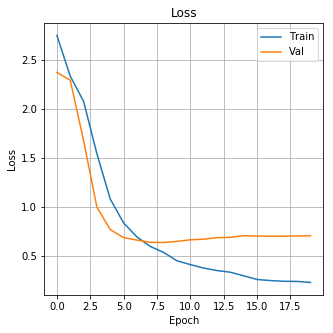

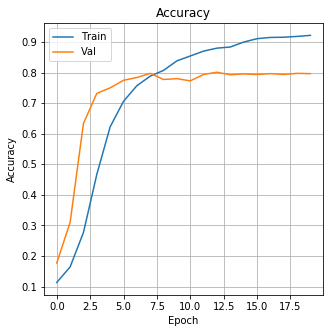

In [14]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.grid(True)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.grid(True)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
f = open("gru-model.txt", 'w')
f.write(" ".join([str(num) for num in train_losses]) + "\n")
f.write(" ".join([str(num) for num in val_losses]) + "\n")
f.write(" ".join([str(num) for num in train_acc]) + "\n")
f.write(" ".join([str(num) for num in val_acc]) + "\n")
f.close()

In [16]:
model_name = "ivector-model"

best_epoch = np.argmax(val_acc) + 1

saver = tf.train.Saver(max_to_keep=None)
saver.restore(sess, "./checkpoints/{}-{}".format(model_name, best_epoch))
print("Restoring {}-{}".format(model_name, best_epoch))

Restoring ivector-model-13


In [18]:
predictions = tf.argmax(y_out, axis=1)
feed_dict = {ivectors : X_val,
             y: y_val,
             is_training: False,
             dropout: 0.2,
             learning_rate: 1e-3
            }
out = sess.run([predictions], feed_dict=feed_dict)[0]

NameError: name 'X_val' is not defined

In [17]:
class_accs = np.zeros(11)
for i in range(1100):
    class_accs[y_val[i]] += 1 if y_val[i] == out[i] else 0
print("\n".join([str(int(acc)) for acc in class_accs]))
print(np.mean(y_val == out))

NameError: name 'out' is not defined